In [5]:
# Initial Setup and Imports
import pandas as pd
from google.cloud import bigquery
from google.cloud.bigquery import LoadJobConfig, WriteDisposition
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from minisom import MiniSom
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.colors as mcolors
from kneed import KneeLocator

In [6]:
# Sets the GOOGLE_APPLICATION_CREDENTIALS environment variable for GCP authentication
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(Path.home() / ".keys/gcp_service_account.json")

In [7]:
# Set Matplotlib style for better aesthetics
plt.style.use('seaborn-v0_8-darkgrid')

# Initialize BigQuery client
client = bigquery.Client()

# Define project and dataset for BigQuery
project_id = "module-2-assignment-project"
dataset = "analytics_olist_ecommerce"

In [8]:
def run_query(query, description="query"):
    """
    Executes a BigQuery SQL query and returns the result as a Pandas DataFrame.
    Handles potential query failures gracefully.
    """
    try:
        print(f"    Executing BigQuery {description}...")
        return client.query(query).to_dataframe()
    except Exception as e:
        print(f"❌ BigQuery {description} failed: {e}")
        return None

In [9]:
def calculate_rfm(df):
    """
    Calculates Recency, Frequency, and Monetary (RFM) features for customers
    based on customer_unique_id.
    """
    df['order_purchase_date'] = pd.to_datetime(df['order_purchase_date'])
    current_date = df['order_purchase_date'].max() + pd.Timedelta(days=1)

    # Group by customer_unique_id for RFM
    rfm_df = df.groupby('customer_unique_id').agg(
        Recency=('order_purchase_date', lambda date: (current_date - date.max()).days),
        Frequency=('order_id', 'nunique'), # Count unique orders for the unique customer
        Monetary=('price', 'sum')
    ).reset_index()
    return rfm_df

In [10]:
def customer_segmentation_input_df(
    dim_customer: pd.DataFrame,
    fact_orders: pd.DataFrame,
    fact_sales: pd.DataFrame,
    fact_payments: pd.DataFrame,
    fact_reviews: pd.DataFrame,
    dim_product: pd.DataFrame
) -> pd.DataFrame:
    """
    Generates a comprehensive DataFrame with features for customer segmentation
    by merging and aggregating data from various dimension and fact tables,
    using customer_unique_id as the primary unit of analysis.
    """
    # Merge dim_customer with fact_orders to get customer_unique_id linked to orders
    customer_orders_base = fact_orders.merge(dim_customer[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

    # Merge with fact_sales to get item-level details per order, linked to customer_unique_id
    customer_order_details = customer_orders_base.merge(
        fact_sales[['order_id', 'product_id', 'price', 'order_item_id']],
        on='order_id',
        how='left'
    )

    # RFM Features - Group by customer_unique_id
    rfm_df = calculate_rfm(customer_order_details)

    # Order related features - Group by customer_unique_id
    order_features = customer_order_details.groupby('customer_unique_id').agg(
        number_of_orders=('order_id', 'nunique'), # Count unique orders for the unique customer
        avg_order_value=('price', 'mean'),
        total_order_items=('order_item_id', 'count') # Total items across all orders for the unique customer
    ).reset_index()

    # Linker for reviews and payments to customer_unique_id
    order_customer_unique_linker = fact_orders.merge(
        dim_customer[['customer_id', 'customer_unique_id']],
        on='customer_id',
        how='left'
    )[['order_id', 'customer_unique_id']].drop_duplicates()

    # Payment related features - Group by customer_unique_id
    payment_features = fact_payments.merge(order_customer_unique_linker, on='order_id', how='left').groupby('customer_unique_id').agg(
        total_payment_value=('payment_value', 'sum'),
        avg_payment_installments=('payment_installments', 'mean')
    ).reset_index()

    # Review features - Group by customer_unique_id
    customer_reviews_merged = fact_reviews.merge(order_customer_unique_linker, on='order_id', how='left')
    review_features = customer_reviews_merged.groupby('customer_unique_id').agg(
        avg_review_score=('review_score', 'mean'),
        num_reviews=('review_id', 'count')
    ).reset_index()

    # Product related features - Group by customer_unique_id
    sales_with_products = fact_sales.merge(dim_product, on='product_id', how='left')
    # Merge sales_with_products with order_customer_unique_linker to get customer_unique_id
    product_features = sales_with_products.merge(order_customer_unique_linker, on='order_id', how='left').groupby('customer_unique_id').agg(
        avg_product_category_value=('price', 'mean'),
        num_unique_products=('product_id', 'nunique'),
        most_frequent_category=('product_category_name', lambda x: x.mode()[0] if not x.mode().empty else None)
    ).reset_index()

    # Start with unique customer_unique_ids from dim_customer
    customer_features_df = dim_customer[['customer_unique_id', 'zip_code_prefix']].drop_duplicates().copy()

    dfs_to_merge = [
        rfm_df,
        order_features,
        payment_features,
        review_features,
        product_features
    ]

    # Merge all features into a single DataFrame using customer_unique_id
    for df in dfs_to_merge:
        customer_features_df = customer_features_df.merge(df, on='customer_unique_id', how='left')

    # Handle missing values: fill numerical NaNs with 0, categorical with 'Unknown'
    numerical_cols = customer_features_df.select_dtypes(include=np.number).columns
    for col in numerical_cols:
        customer_features_df[col] = customer_features_df[col].fillna(0)

    if 'most_frequent_category' in customer_features_df.columns:
        customer_features_df['most_frequent_category'] = customer_features_df['most_frequent_category'].fillna('Unknown')

    # Drop non-numeric or non-segmentation relevant columns
    customer_features_df = customer_features_df.drop(columns=['zip_code_prefix', 'most_frequent_category'], errors='ignore')

    return customer_features_df

In [11]:
def scaled_customer_features(customer_seg_input: pd.DataFrame) -> pd.DataFrame:
    """
    Selects relevant features and scales them using StandardScaler.
    Scaling is crucial for distance-based algorithms like SOM and KMeans.
    The index of the returned DataFrame is customer_unique_id.
    """
    # Exclude 'customer_unique_id' from scaling as it is the identifier
    features_to_scale = customer_seg_input.drop(columns=['customer_unique_id'], errors='ignore')

    scaler = StandardScaler()
    scaled_features_array = scaler.fit_transform(features_to_scale)

    scaled_features_df = pd.DataFrame(
        scaled_features_array,
        columns=features_to_scale.columns,
        index=customer_seg_input['customer_unique_id'] # Use customer_unique_id as index
    )
    return scaled_features_df

In [12]:
# Load Data from BigQuery Marts
print(f"Loading data from BigQuery dataset: `{project_id}.{dataset}`...")

dim_customer_df = run_query(f"SELECT * FROM `{project_id}.{dataset}.dim_customer`", "dim_customer")
fact_orders_df = run_query(f"SELECT * FROM `{project_id}.{dataset}.fact_orders`", "fact_orders")
fact_sales_df = run_query(f"SELECT * FROM `{project_id}.{dataset}.fact_sales`", "fact_sales")
fact_payments_df = run_query(f"SELECT * FROM `{project_id}.{dataset}.fact_payments`", "fact_payments")
fact_reviews_df = run_query(f"SELECT * FROM `{project_id}.{dataset}.fact_reviews`", "fact_reviews")
dim_product_df = run_query(f"SELECT * FROM `{project_id}.{dataset}.dim_product`", "dim_product")

if any(df is None for df in [dim_customer_df, fact_orders_df, fact_sales_df, fact_payments_df, fact_reviews_df, dim_product_df]):
    print("❌ Error: Not all necessary Dataframes loaded successfully from BigQuery. Please check your BigQuery connection, project ID, dataset ID, and table names.")
else:
    print("✅ All necessary Dataframes loaded successfully from BigQuery.")

    print("\n--- Generating Customer Segmentation Input DataFrame (Feature Engineering) ---")
    customer_seg_input_df = customer_segmentation_input_df(
        dim_customer_df,
        fact_orders_df,
        fact_sales_df,
        fact_payments_df,
        fact_reviews_df,
        dim_product_df
    )
    print(f"Shape of customer_seg_input_df: {customer_seg_input_df.shape}")
    print("Head of customer_seg_input_df:")
    print(customer_seg_input_df.head())

    print("\n--- Scaling Customer Features ---")
    scaled_cust_features = scaled_customer_features(customer_seg_input_df)
    print(f"Shape of scaled_cust_features: {scaled_cust_features.shape}")
    print("Head of scaled_cust_features:")
    print(scaled_cust_features.head())


Loading data from BigQuery dataset: `module-2-assignment-project.analytics_olist_ecommerce`...
    Executing BigQuery dim_customer...
    Executing BigQuery fact_orders...
    Executing BigQuery fact_sales...
    Executing BigQuery fact_payments...
    Executing BigQuery fact_reviews...
    Executing BigQuery dim_product...
✅ All necessary Dataframes loaded successfully from BigQuery.

--- Generating Customer Segmentation Input DataFrame (Feature Engineering) ---
Shape of customer_seg_input_df: (96350, 13)
Head of customer_seg_input_df:
                 customer_unique_id  Recency  Frequency  Monetary  \
0  5203034a29c3d294713bf8ccbd5d05a6      450          1    109.90   
1  36b1c0516f123351ffa87430416dcae5      421          1    276.14   
2  f7d7fc0a59ef4363fdce6e3aa069d498      190          2    124.89   
3  94742cd1fbac9146be7e2a139b63e13c      454          1     31.90   
4  5dbba6c01268a8ad43f79157bf4454a0      242          2    359.18   

   number_of_orders  avg_order_value  tota

In [28]:
def trained_som_model(scaled_customer_features: pd.DataFrame) -> MiniSom:
    # Define SOM hyperparameters
    m = 80
    n = 40
    input_len = scaled_customer_features.shape[1]
    sigma = 1.2
    learning_rate = 0.15
    random_seed = 42
    num_iterations = 1000000

    som = MiniSom(m, n, input_len, sigma=sigma, learning_rate=learning_rate,
                  random_seed=random_seed)

    som.random_weights_init(scaled_customer_features.values)

    print(f"Training SOM with {num_iterations} iterations...")
    som.train_random(scaled_customer_features.values, num_iterations, verbose=True)
    print("SOM training complete.")

    return som

In [29]:
print("\n--- Training SOM Model ---")
som_model = trained_som_model(scaled_cust_features)
print(f"SOM model trained with map dimensions: {som_model.get_weights().shape[0]}x{som_model.get_weights().shape[1]} neurons.")


--- Training SOM Model ---
Training SOM with 1000000 iterations...
 [ 1000000 / 1000000 ] 100% - 0:00:00 left 
 quantization error: 0.24440185097100145
SOM training complete.
SOM model trained with map dimensions: 80x40 neurons.


In [30]:
print("\n--- Internal Validation Metrics: Self-Organizing Map (SOM)-Specific Quality Metrics ---")

quant_error = som_model.quantization_error(scaled_cust_features.values)
print(f"Quantization Error: {quant_error:.4f} (Expected: <0.25)")

topo_error = som_model.topographic_error(scaled_cust_features.values)
print(f"Topographic Error: {topo_error:.4f} (Acceptable: <0.25, Good: <0.15)")


--- Internal Validation Metrics: Self-Organizing Map (SOM)-Specific Quality Metrics ---
Quantization Error: 0.2444 (Expected: <0.25)
Topographic Error: 0.2412 (Acceptable: <0.25, Good: <0.15)



--- Elbow Method for K-Means on SOM Neurons (Automated with Kneed) ---


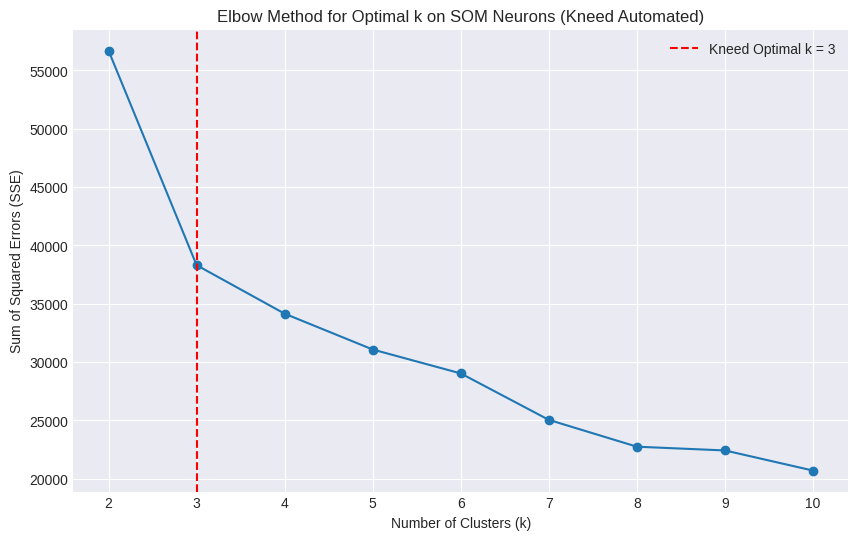

The optimal K-value determined by Kneed is: 3


In [40]:
print("\n--- Elbow Method for K-Means on SOM Neurons (Automated with Kneed) ---")

# Get the SOM neuron weights
# MiniSom stores weights as a 3D array (x_dim, y_dim, input_features)
# Reshape it to a 2D array (num_neurons, input_features) for KMeans
som_weights = som_model.get_weights().reshape(-1, som_model.get_weights().shape[2])

sse = []
k_range = range(2, 11) # Test K from 2 to 10
for k in k_range:
    # Use MiniBatchKMeans for potentially faster elbow calculation
    kmeans_temp = MiniBatchKMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_temp.fit(som_weights)
    sse.append(kmeans_temp.inertia_) # inertia_ is the SSE

# Use KneeLocator to find the elbow point
# S=1.0 is a common sensitivity parameter for KneeLocator
# curve='convex' and direction='decreasing' are standard for elbow method
kneedle = KneeLocator(k_range, sse, S=1.0, curve='convex', direction='decreasing')
optimal_k_kneed = kneedle.elbow

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k on SOM Neurons (Kneed Automated)')
plt.xticks(k_range) # Ensure all k values are shown on x-axis
plt.grid(True)

# Add a vertical line at the kneed-determined elbow
if optimal_k_kneed is not None:
    plt.axvline(x=optimal_k_kneed, color='r', linestyle='--', label=f'Kneed Optimal k = {optimal_k_kneed}')
    plt.legend()

plt.show()

if optimal_k_kneed is not None:
    print(f"The optimal K-value determined by Kneed is: {optimal_k_kneed}")
else:
    print("Kneed could not find a clear elbow point. Visual inspection is recommended.")

In [41]:
def trained_kmeans_on_som_neurons_model(som_model: MiniSom) -> KMeans:
    som_weights = som_model.get_weights().reshape(-1, som_model.get_weights().shape[2])
    # k-value determined using Elbow Method analysis above
    n_clusters = optimal_k_kneed

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(som_weights)
    print(f"K-Means clustering on SOM neurons complete. Found {kmeans.n_clusters} clusters.")

    return kmeans

In [42]:
print("\n--- Training K-Means on SOM Neurons ---")
kmeans_som_model = trained_kmeans_on_som_neurons_model(som_model)
print(f"K-Means on SOM neurons trained with {kmeans_som_model.n_clusters} clusters.")


--- Training K-Means on SOM Neurons ---
K-Means clustering on SOM neurons complete. Found 3 clusters.
K-Means on SOM neurons trained with 3 clusters.


In [37]:
def customer_som_kmeans_segments(
    customer_segmentation_input_df: pd.DataFrame,
    scaled_customer_features: pd.DataFrame,
    som_model: MiniSom,
    kmeans_som_model: KMeans
) -> pd.DataFrame:
    """
    Assigns a segment ID to each customer (unique_id) using the trained SOM and KMeans models.
    """
    # DIAGNOSTIC: Print columns of input DataFrames
    print(f"DEBUG: customer_segmentation_input_df columns: {customer_segmentation_input_df.columns.tolist()}")
    print(f"DEBUG: scaled_customer_features index name: {scaled_customer_features.index.name}, columns: {scaled_customer_features.columns.tolist()}")

    customer_bmus = np.array([som_model.winner(x) for x in scaled_customer_features.values])
    neuron_cluster_labels = kmeans_som_model.labels_

    som_x, som_y, _ = som_model.get_weights().shape
    neuron_to_segment_map = {}
    for i in range(som_x):
        for j in range(som_y):
            flattened_index = i * som_y + j # Flatten 2D neuron index to 1D for K-Means labels
            neuron_to_segment_map[(i, j)] = neuron_cluster_labels[flattened_index]

    customer_segment_ids = [neuron_to_segment_map[tuple(bmu)] for bmu in customer_bmus]

    segmented_df = pd.DataFrame({
        'customer_unique_id': scaled_customer_features.index, # Use the index (customer_unique_id)
        'segment_id': customer_segment_ids
    })

    # Merge the segment IDs back into the original customer features DataFrame
    final_customer_dim_with_segments = customer_segmentation_input_df.merge(
        segmented_df, on='customer_unique_id', how='left'
    )
    final_customer_dim_with_segments['segment_id'] = final_customer_dim_with_segments['segment_id'].astype(int)

    return final_customer_dim_with_segments

In [38]:
print("\n--- Assigning Customer Segments ---")
customer_segments_df = customer_som_kmeans_segments(
    customer_seg_input_df,
    scaled_cust_features,
    som_model,
    kmeans_som_model
)
print(f"Shape of customer_segments_df: {customer_segments_df.shape}")
print("Head of customer_segments_df:")
print(customer_segments_df.head())


--- Assigning Customer Segments ---
DEBUG: customer_segmentation_input_df columns: ['customer_unique_id', 'Recency', 'Frequency', 'Monetary', 'number_of_orders', 'avg_order_value', 'total_order_items', 'total_payment_value', 'avg_payment_installments', 'avg_review_score', 'num_reviews', 'avg_product_category_value', 'num_unique_products']
DEBUG: scaled_customer_features index name: customer_unique_id, columns: ['Recency', 'Frequency', 'Monetary', 'number_of_orders', 'avg_order_value', 'total_order_items', 'total_payment_value', 'avg_payment_installments', 'avg_review_score', 'num_reviews', 'avg_product_category_value', 'num_unique_products']
Shape of customer_segments_df: (96866, 14)
Head of customer_segments_df:
                 customer_unique_id  Recency  Frequency  Monetary  \
0  5203034a29c3d294713bf8ccbd5d05a6      450          1    109.90   
1  36b1c0516f123351ffa87430416dcae5      421          1    276.14   
2  f7d7fc0a59ef4363fdce6e3aa069d498      190          2    124.89   


In [39]:
print("\n--- Internal Validation Metrics: Cluster Validity Metrics ---")

features_and_labels = pd.merge(
    scaled_cust_features.reset_index(),
    customer_segments_df[['customer_unique_id', 'segment_id']],
    on='customer_unique_id',
    how='inner'
)

features_for_metrics = features_and_labels.drop(columns=['customer_unique_id', 'segment_id']).values
labels_for_metrics = features_and_labels['segment_id'].values

if len(np.unique(labels_for_metrics)) > 1 and len(features_for_metrics) > 1:
    silhouette_avg = silhouette_score(features_for_metrics, labels_for_metrics)
    print(f"Silhouette Score: {silhouette_avg:.4f} (Reasonable: 0.5-0.7, Strong: 0.7-1.0)")

    davies_bouldin_idx = davies_bouldin_score(features_for_metrics, labels_for_metrics)
    print(f"Davies-Bouldin Index: {davies_bouldin_idx:.4f} (Good: <1.0, Excellent: <0.5)")
else:
    print("\nCannot compute Silhouette Score or Davies-Bouldin Index: Not enough unique clusters or data points after segment assignment.")


--- Internal Validation Metrics: Cluster Validity Metrics ---
Silhouette Score: 0.6967 (Reasonable: 0.5-0.7, Strong: 0.7-1.0)
Davies-Bouldin Index: 0.6919 (Good: <1.0, Excellent: <0.5)



--- U-Matrix (Unified Distance Matrix) Visualization ---


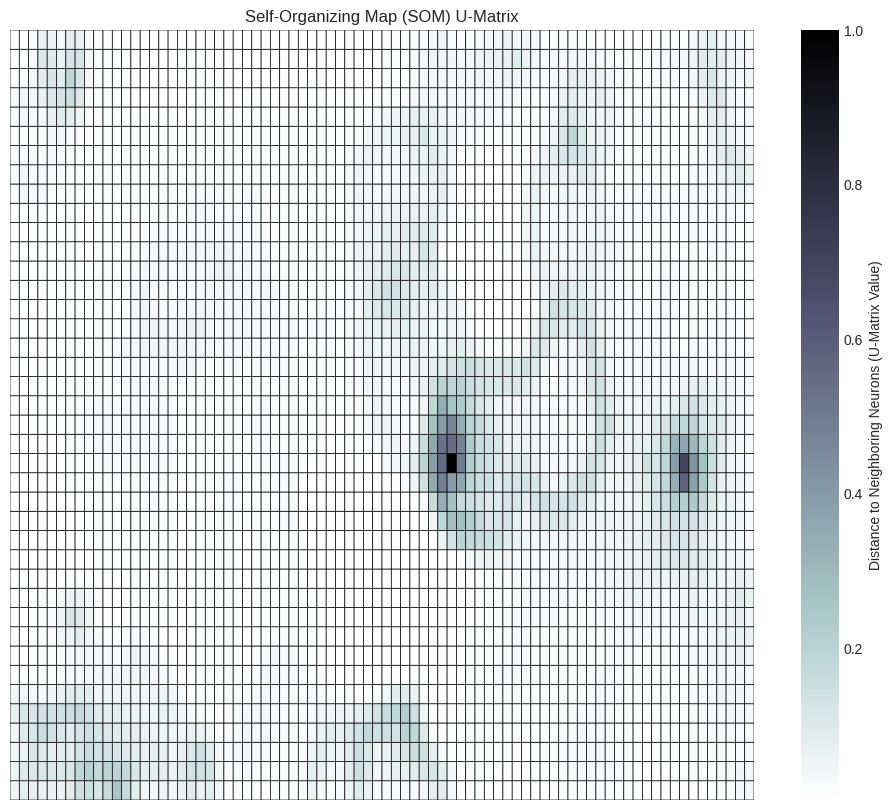

Darker areas in the U-Matrix represent high distances, indicating cluster separation.


In [43]:
print("\n--- U-Matrix (Unified Distance Matrix) Visualization ---")
u_matrix = som_model.distance_map()
plt.figure(figsize=(12, 10))
plt.pcolor(u_matrix.T, cmap='bone_r', edgecolors='k', linewidths=0.5)
plt.colorbar(label='Distance to Neighboring Neurons (U-Matrix Value)')
plt.title('Self-Organizing Map (SOM) U-Matrix')
plt.xticks([])
plt.yticks([])
plt.show()
print("Darker areas in the U-Matrix represent high distances, indicating cluster separation.")


--- Component Planes Visualization ---


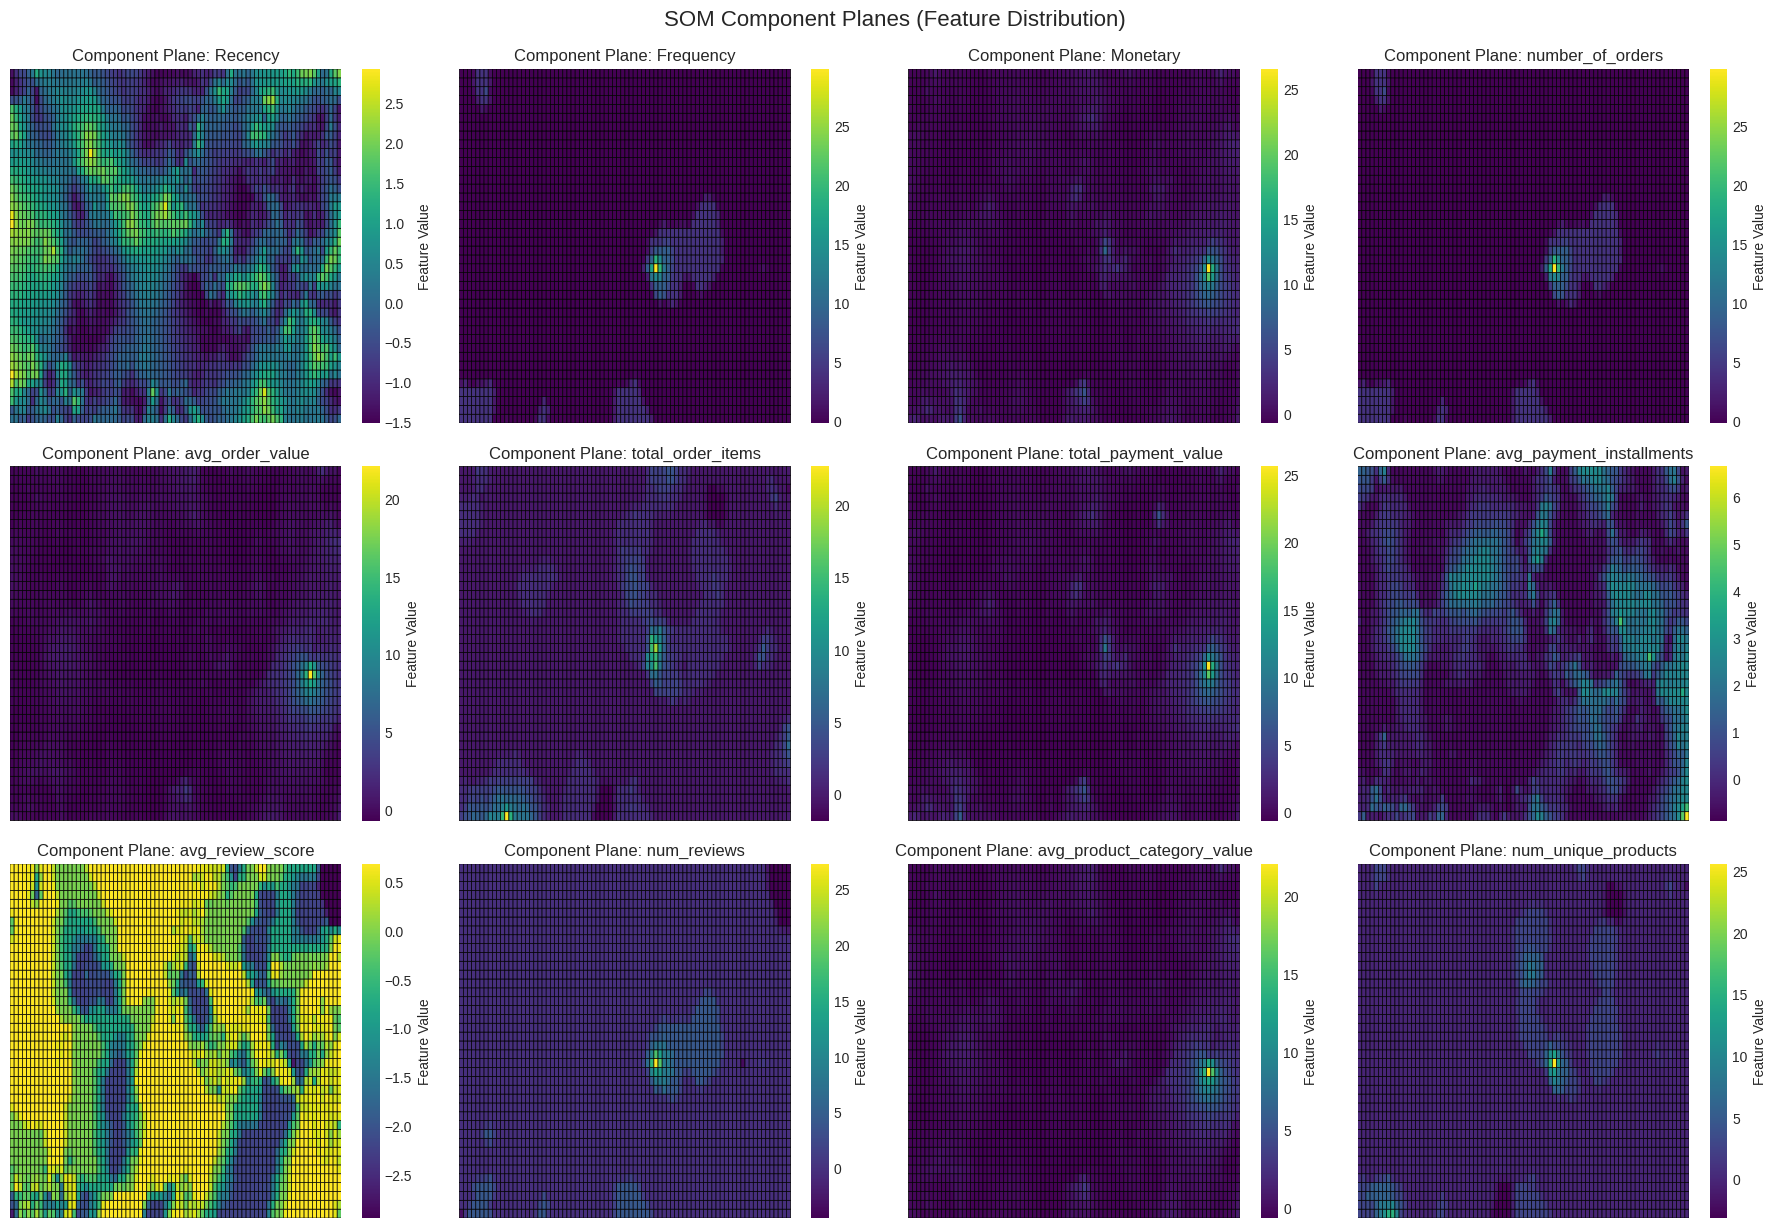

Each component plane shows the distribution of a single feature across the SOM. This helps understand what characteristics neurons (and thus segments) represent.


In [44]:
print("\n--- Component Planes Visualization ---")
num_features = scaled_cust_features.shape[1]
feature_names = scaled_cust_features.columns.tolist()
som_x, som_y = som_model.get_weights().shape[0], som_model.get_weights().shape[1]

num_rows = int(np.ceil(num_features/4))
fig, axes = plt.subplots(num_rows, 4, figsize=(18, 4 * num_rows))
axes = axes.flatten()

for i, feature_idx in enumerate(range(num_features)):
    if i < len(axes):
        ax = axes[i]
        feature_map = som_model.get_weights()[:, :, feature_idx].T
        c = ax.pcolor(feature_map, cmap='viridis', edgecolors='k', linewidths=0.5)
        fig.colorbar(c, ax=ax, label='Feature Value')
        ax.set_title(f'Component Plane: {feature_names[feature_idx]}')
        ax.set_xticks([])
        ax.set_yticks([])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('SOM Component Planes (Feature Distribution)', y=1.02, fontsize=16)
plt.show()
print("Each component plane shows the distribution of a single feature across the SOM. This helps understand what characteristics neurons (and thus segments) represent.")


--- U-Matrix with Customer Data Points Mapped ---


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


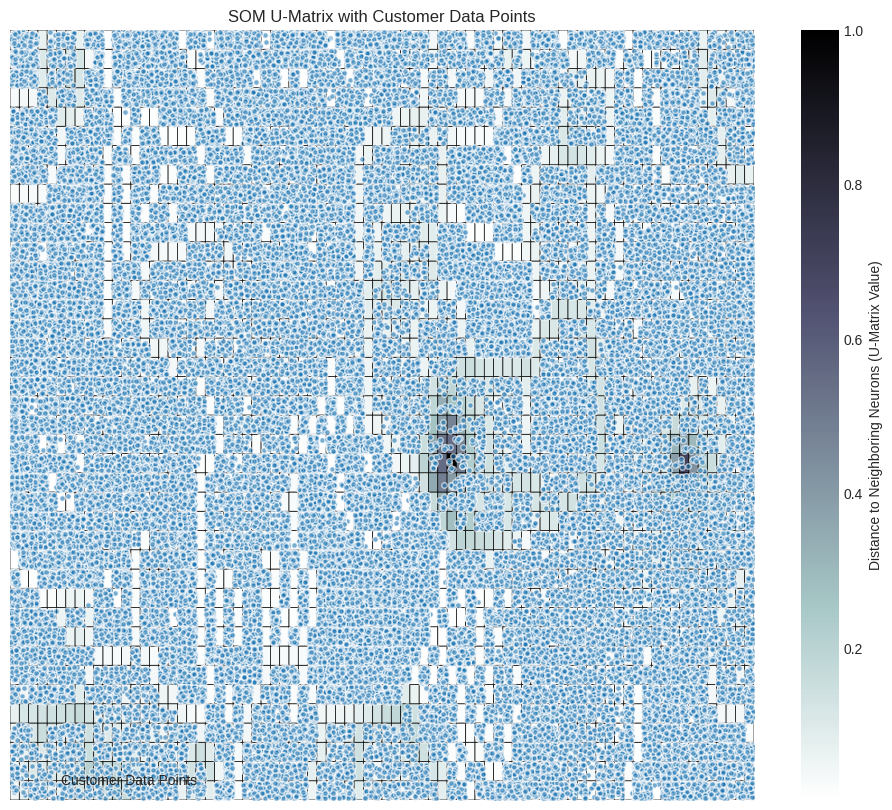

Customer data points are clustered in regions of low U-Matrix values, indicating cohesive groups.


In [ ]:
print("\n--- U-Matrix with Customer Data Points Mapped ---")
customer_bmus = np.array([som_model.winner(x) for x in scaled_cust_features.values])

plt.figure(figsize=(12, 10))
plt.pcolor(u_matrix.T, cmap='bone_r', edgecolors='k', linewidths=0.5)
plt.colorbar(label='Distance to Neighboring Neurons (U-Matrix Value)')

offset_x = np.random.rand(customer_bmus.shape[0]) * 0.8 + 0.1
offset_y = np.random.rand(customer_bmus.shape[0]) * 0.8 + 0.1

plt.plot(customer_bmus[:, 0] + offset_x, customer_bmus[:, 1] + offset_y,
          'o', markerfacecolor='C0', markeredgecolor='w', markersize=4, alpha=0.6,
          label='Customer Data Points')

plt.title('SOM U-Matrix with Customer Data Points')
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()
print("Customer data points are clustered in regions of low U-Matrix values, indicating cohesive groups.")

In [46]:
# Initialize segment names using numbers for now
SEGMENT_NAMES = {
    0: "0",
    1: "1",
    2: "2"
}


--- SOM Map with Segment Names and Numbers ---


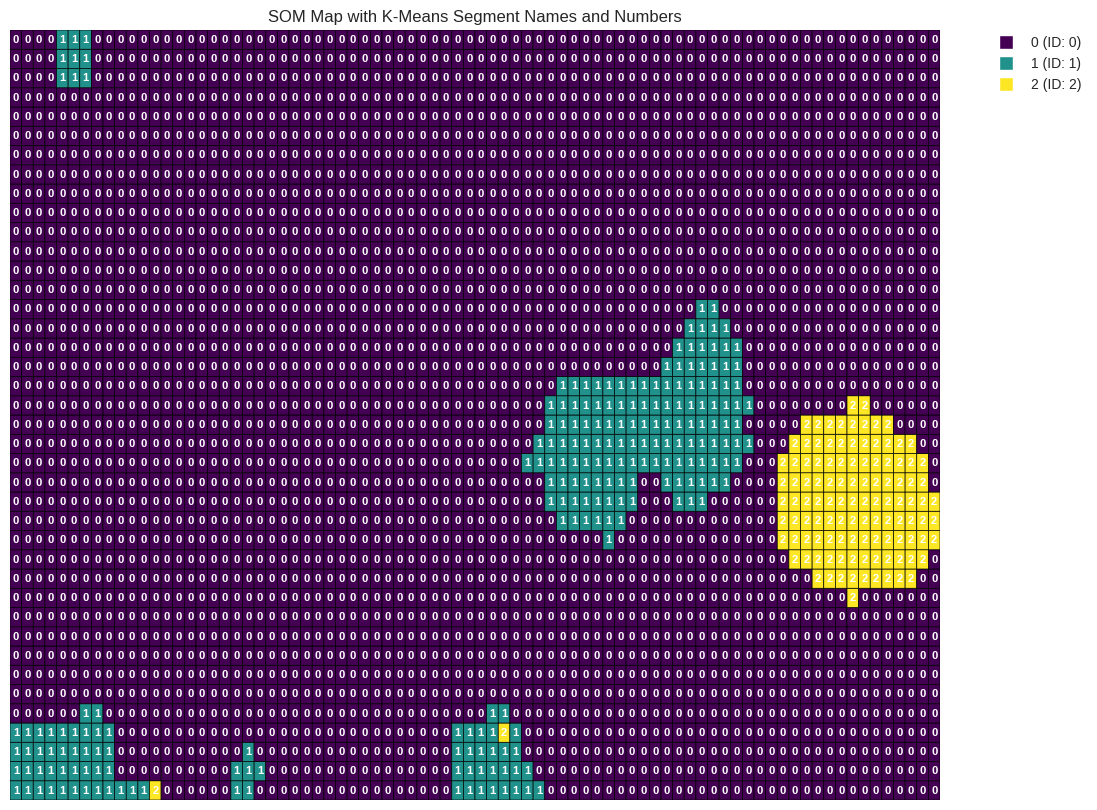

This map shows the geographical distribution of the derived segments across the SOM grid.
Neurons with the same color and label belong to the same K-Means segment.


In [47]:
print("\n--- SOM Map with Segment Names and Numbers ---")
neuron_cluster_labels = kmeans_som_model.labels_
som_x, som_y = som_model.get_weights().shape[0], som_model.get_weights().shape[1]
segment_map = neuron_cluster_labels.reshape(som_x, som_y).T

plt.figure(figsize=(12, 10))

# Create a custom colormap and normalization for the segments
unique_segments = np.unique(neuron_cluster_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_segments)))
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(len(unique_segments) + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

p = plt.pcolor(segment_map, cmap=cmap, norm=norm, edgecolors='k', linewidths=0.5)

# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], marker='s', color='w', label=f'{SEGMENT_NAMES.get(seg_id, "Unknown Segment")} (ID: {seg_id})',
                              markerfacecolor=cmap(norm(seg_id)), markersize=10)
                  for seg_id in sorted(unique_segments)]

plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Add segment numbers to each neuron
for i in range(som_x):
    for j in range(som_y):
        plt.text(i + 0.5, j + 0.5, str(segment_map[j, i]),
                            ha='center', va='center', color='white', fontsize=8, fontweight='bold')

plt.title('SOM Map with K-Means Segment Names and Numbers')
plt.xticks([])
plt.yticks([])
plt.show()
print("This map shows the geographical distribution of the derived segments across the SOM grid.")
print("Neurons with the same color and label belong to the same K-Means segment.")

### Segment Naming and Actionable Insights
---

**Segment 0 (ID: 0 - Purple Cluster): "The Vast Unengaged / Lapsed Base"**

* **Location on SOM Map:** This is the **dominant segment**, covering the vast majority of the SOM map (the large purple area).
* **Key Characteristics (from Component Planes in the purple regions):**
    * **Recency:** Very High (meaning a long time since their last purchase).
    * **Frequency:** Very Low (likely single purchases).
    * **Monetary:** Very Low (small total spending).
    * **Number of Orders:** Very Low (mostly one order).
    * **Avg Order Value, Total Order Items, Total Payment Value:** All very low.
    * **Avg Payment Installments:** Low/None.
    * **Avg Review Score:** Generally average to slightly below average.
    * **Num Reviews:** Low (typically one review).
    * **Avg Product Category Value, Num Unique Products:** Low.

* **Useful Insights & Strategy:**
    * **Insight:** This segment represents a massive pool of customers who made a single, low-value purchase a long time ago and have since become inactive. They are likely "one-and-done" customers who either didn't find compelling reasons to return or whose initial purchase didn't lead to further engagement.
    * **Challenge:** Reactivating this segment is difficult due to their low historical engagement and long dormancy. Their sheer size means even a small success rate can yield results, but efforts must be cost-effective.
    * **Strategy:**
        * **Low-Cost Reactivation Campaigns:** Focus on highly targeted, low-cost campaigns (e.g., email re-engagement with strong discounts on entry-level products, or surveys to understand why they haven't returned). Avoid high-cost advertising for this group unless specifically targeting reactivation.
        * **Churn Prevention (Past):** For newly identified customers falling into this pattern, proactive intervention is key.
        * **Audience Segmentation for Ads:** Exclude this segment from broad, high-cost advertising campaigns to optimize ad spend.
        * **Data Quality Check:** Investigate if some of these are truly inactive or if there are data collection issues.

---

**Segment 1 (ID: 1 - Teal/Green Cluster): "The Engaged & Growing Buyers"**

* **Location on SOM Map:** This segment forms a significant, connected cluster, primarily in the middle-right and bottom-left regions of the map.
* **Key Characteristics (from Component Planes in the teal/green regions):**
    * **Recency:** Low (meaning recent purchases).
    * **Frequency:** Moderate to High (more frequent purchases than Segment 0).
    * **Monetary:** Moderate to High (higher total spending).
    * **Number of Orders:** Higher.
    * **Avg Order Value, Total Order Items, Total Payment Value:** Moderate to High.
    * **Avg Payment Installments:** Higher (indicating use of credit/installments for larger purchases).
    * **Avg Review Score:** High (positive feedback).
    * **Num Reviews:** Higher.
    * **Avg Product Category Value, Num Unique Products:** Moderate to High.

* **Useful Insights & Strategy:**
    * **Insight:** These are your active, valuable, and likely growing customers. They purchase recently, more frequently, spend more, and are generally satisfied. They are key to your business's ongoing revenue and have potential for increased loyalty and value.
    * **Opportunity:** Nurture loyalty, maximize Customer Lifetime Value (CLV), and encourage advocacy.
    * **Strategy:**
        * **Loyalty Programs:** Offer exclusive discounts, early access to new products, or loyalty points to reward their engagement.
        * **Personalized Recommendations:** Leverage their purchase history (product categories, unique products) to offer highly relevant cross-sell and up-sell recommendations.
        * **Retention Campaigns:** Focus on ensuring continued satisfaction and repeat purchases through personalized communication.
        * **Feedback Loop:** Actively solicit and respond to reviews and feedback to maintain high satisfaction and address any issues promptly.
        * **Installment Promotion:** If they use installments, highlight flexible payment options for higher-value items or encourage larger basket sizes.

---

**Segment 2 (ID: 2 - Yellow Cluster): "The Recent, Highly Satisfied Explorers"**

* **Location on SOM Map:** This segment appears in smaller, more scattered clusters, notably in the top-right and some isolated spots.
* **Key Characteristics (from Component Planes in the yellow regions):**
    * **Recency:** Very Low (meaning very recent purchases).
    * **Frequency:** Very Low (almost exclusively single purchases).
    * **Monetary:** Low (small total spending).
    * **Number of Orders:** Very Low (likely one order).
    * **Avg Order Value, Total Order Items, Total Payment Value:** All low.
    * **Avg Payment Installments:** Low/None.
    * **Avg Review Score:** **CRITICALLY: Very High (Bright Yellow)** $\rightarrow$ Extremely Positive Reviews. This is their most distinguishing feature.
    * **Num Reviews:** Moderate (more than Segment 0, but less than Segment 1).
    * **Avg Product Category Value, Num Unique Products:** Low.

* **Useful Insights & Strategy:**
    * **Insight:** This segment consists of very recent, likely first-time buyers who, despite low initial spending, had an exceptionally positive experience. Their high review scores indicate strong satisfaction and significant potential for future growth. They are currently "explorers" of your platform.
    * **Opportunity:** Convert these satisfied first-time buyers into repeat customers and eventually into "Engaged & Growing Buyers." Their positive sentiment is a valuable asset.
    * **Strategy:**
        * **Immediate Post-Purchase Nurturing:** Send personalized follow-up emails (not just transactional) after their first purchase, highlighting benefits, complementary products, and encouraging a second purchase.
        * **Incentivize Repeat Purchase:** Offer a small, time-sensitive discount or free shipping on their next order to encourage a quick return.
        * **Feedback Amplification:** Encourage them to share their positive experience on social media, review platforms, or through referral programs.
        * **Onboarding:** Provide tips or guides related to their purchased product category to enhance their experience and demonstrate value beyond the initial purchase.
        * **Monitor Closely:** Track their behavior closely to see if they transition to Segment 1, indicating successful nurturing.

---

**Conclusion: Actionable Segmentation and Future Refinement**

This 3-segment model provides a clear, actionable, and statistically robust breakdown of the customer base. The excellent Silhouette and Davies-Bouldin scores, coupled with the well-organized SOM, indicate that these segments are distinct, internally cohesive, and highly interpretable for strategic decision-making.

It's important to note that for an initial customer segmentation model, starting with a smaller, more manageable number of clusters (like these 3) is often a pragmatic and effective approach. This allows the marketing, sales, and product teams to:

1.  **Gain immediate clarity:** Understand the core customer archetypes without being overwhelmed by excessive granularity.
2.  **Focus resources:** Prioritize and develop distinct, high-impact strategies for each major group.
3.  **Establish a baseline:** Measure the effectiveness of targeted interventions.

As the business implements specific actions based on these identified segments (e.g., reactivation campaigns for "Lapsed Customers," loyalty programs for "Engaged Buyers," nurturing for "Satisfied Explorers"), we should expect to see shifts in customer behavior and engagement patterns. If these interventions are successful, customers within these broad segments may begin to **differentiate further** based on their responses to your strategies.

In subsequent iterations of the segmentation model (e.g., next quarter or year), these behavioral shifts could naturally lead to the **emergence of more granular, distinct sub-segments or entirely new clusters**. This iterative process of applying business actions, observing changes, and then re-segmenting allows for a continuous refinement of business understanding of the customer base, enabling even more precise and effective targeting over time.


In [48]:
# Define segment names based on analysis
SEGMENT_NAMES = {
    0: "The Vast Unengaged / Lapsed Base",
    1: "The Engaged & Growing Buyers",
    2: "The Recent, Highly Satisfied Explorers"
}


--- SOM Map with Segment Names and Numbers ---


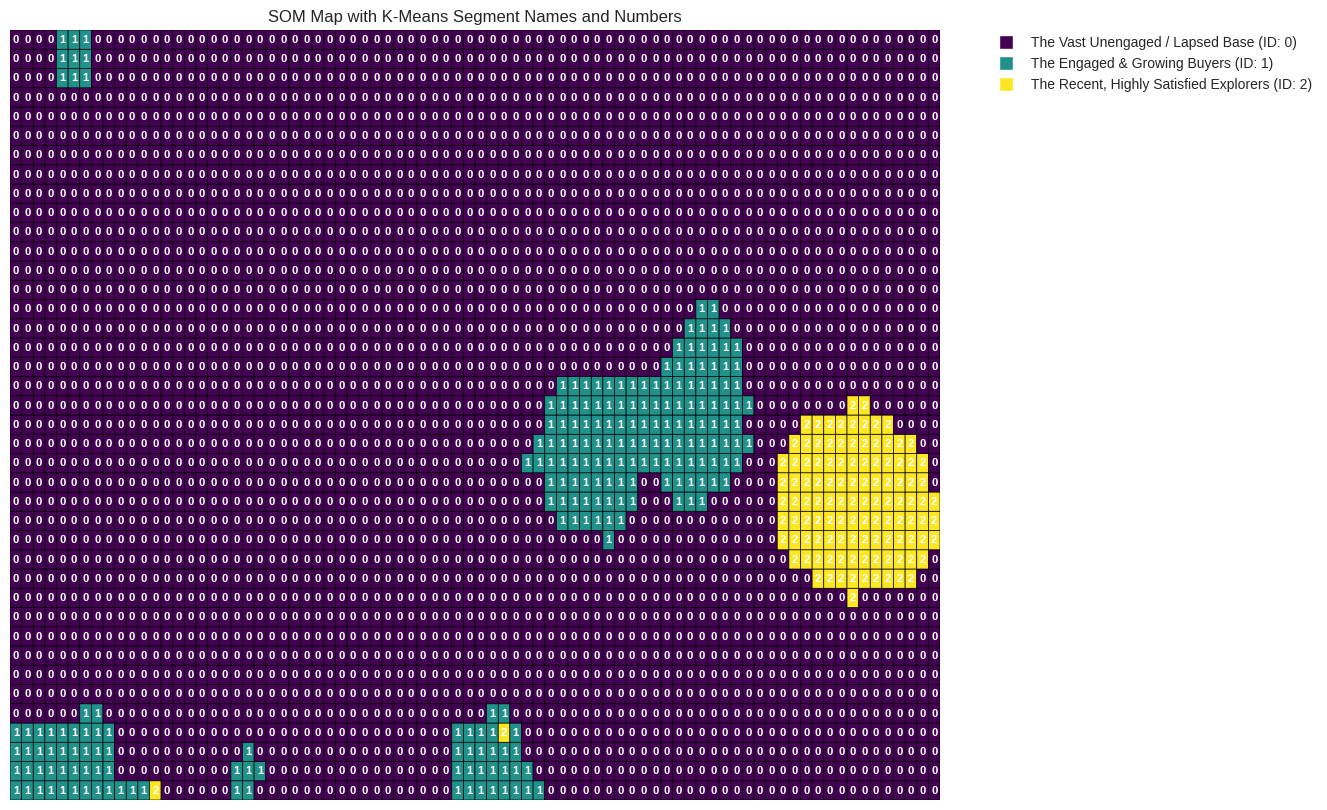

This map shows the geographical distribution of the derived segments across the SOM grid.
Neurons with the same color and label belong to the same K-Means segment.


In [49]:
print("\n--- SOM Map with Segment Names and Numbers ---")
neuron_cluster_labels = kmeans_som_model.labels_
som_x, som_y = som_model.get_weights().shape[0], som_model.get_weights().shape[1]
segment_map = neuron_cluster_labels.reshape(som_x, som_y).T

plt.figure(figsize=(12, 10))

# Create a custom colormap and normalization for the segments
unique_segments = np.unique(neuron_cluster_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_segments)))
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(len(unique_segments) + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

p = plt.pcolor(segment_map, cmap=cmap, norm=norm, edgecolors='k', linewidths=0.5)

# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], marker='s', color='w', label=f'{SEGMENT_NAMES.get(seg_id, "Unknown Segment")} (ID: {seg_id})',
                              markerfacecolor=cmap(norm(seg_id)), markersize=10)
                  for seg_id in sorted(unique_segments)]

plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Add segment numbers to each neuron
for i in range(som_x):
    for j in range(som_y):
        plt.text(i + 0.5, j + 0.5, str(segment_map[j, i]),
                            ha='center', va='center', color='white', fontsize=8, fontweight='bold')

plt.title('SOM Map with K-Means Segment Names and Numbers')
plt.xticks([])
plt.yticks([])
plt.show()
print("This map shows the geographical distribution of the derived segments across the SOM grid.")
print("Neurons with the same color and label belong to the same K-Means segment.")

In [50]:
print("\n--- Preparing dim_segment DataFrame (with names) ---")
segment_data = []
for i in sorted(SEGMENT_NAMES.keys()):
    centroid = kmeans_som_model.cluster_centers_[i]
    segment_name = SEGMENT_NAMES.get(i, f"Segment {i} (Unknown Name)")
    segment_description = f"Description for Segment {i} based on centroid: {np.round(centroid, 2)}"
    segment_data.append({
        'segment_id': i,
        'segment_name': segment_name,
        'segment_description': segment_description,
        'created_at': pd.Timestamp.now()
    })
dim_segment_df = pd.DataFrame(segment_data)
dim_segment_df['segment_id'] = dim_segment_df['segment_id'].astype(int)
print(dim_segment_df.head())

print("\n--- Pipeline Execution Complete! ---")
print("\nSegment Distribution:")
print(customer_segments_df['segment_id'].value_counts().sort_index())


--- Preparing dim_segment DataFrame (with names) ---
   segment_id                            segment_name  \
0           0        The Vast Unengaged / Lapsed Base   
1           1            The Engaged & Growing Buyers   
2           2  The Recent, Highly Satisfied Explorers   

                                 segment_description  \
0  Description for Segment 0 based on centroid: [...   
1  Description for Segment 1 based on centroid: [...   
2  Description for Segment 2 based on centroid: [...   

                  created_at  
0 2025-07-26 00:49:54.681597  
1 2025-07-26 00:49:54.681979  
2 2025-07-26 00:49:54.682134  

--- Pipeline Execution Complete! ---

Segment Distribution:
segment_id
0    91189
1     3739
2     1938
Name: count, dtype: int64



--- Customer Segment Profile Dashboard: Key Feature Distributions ---


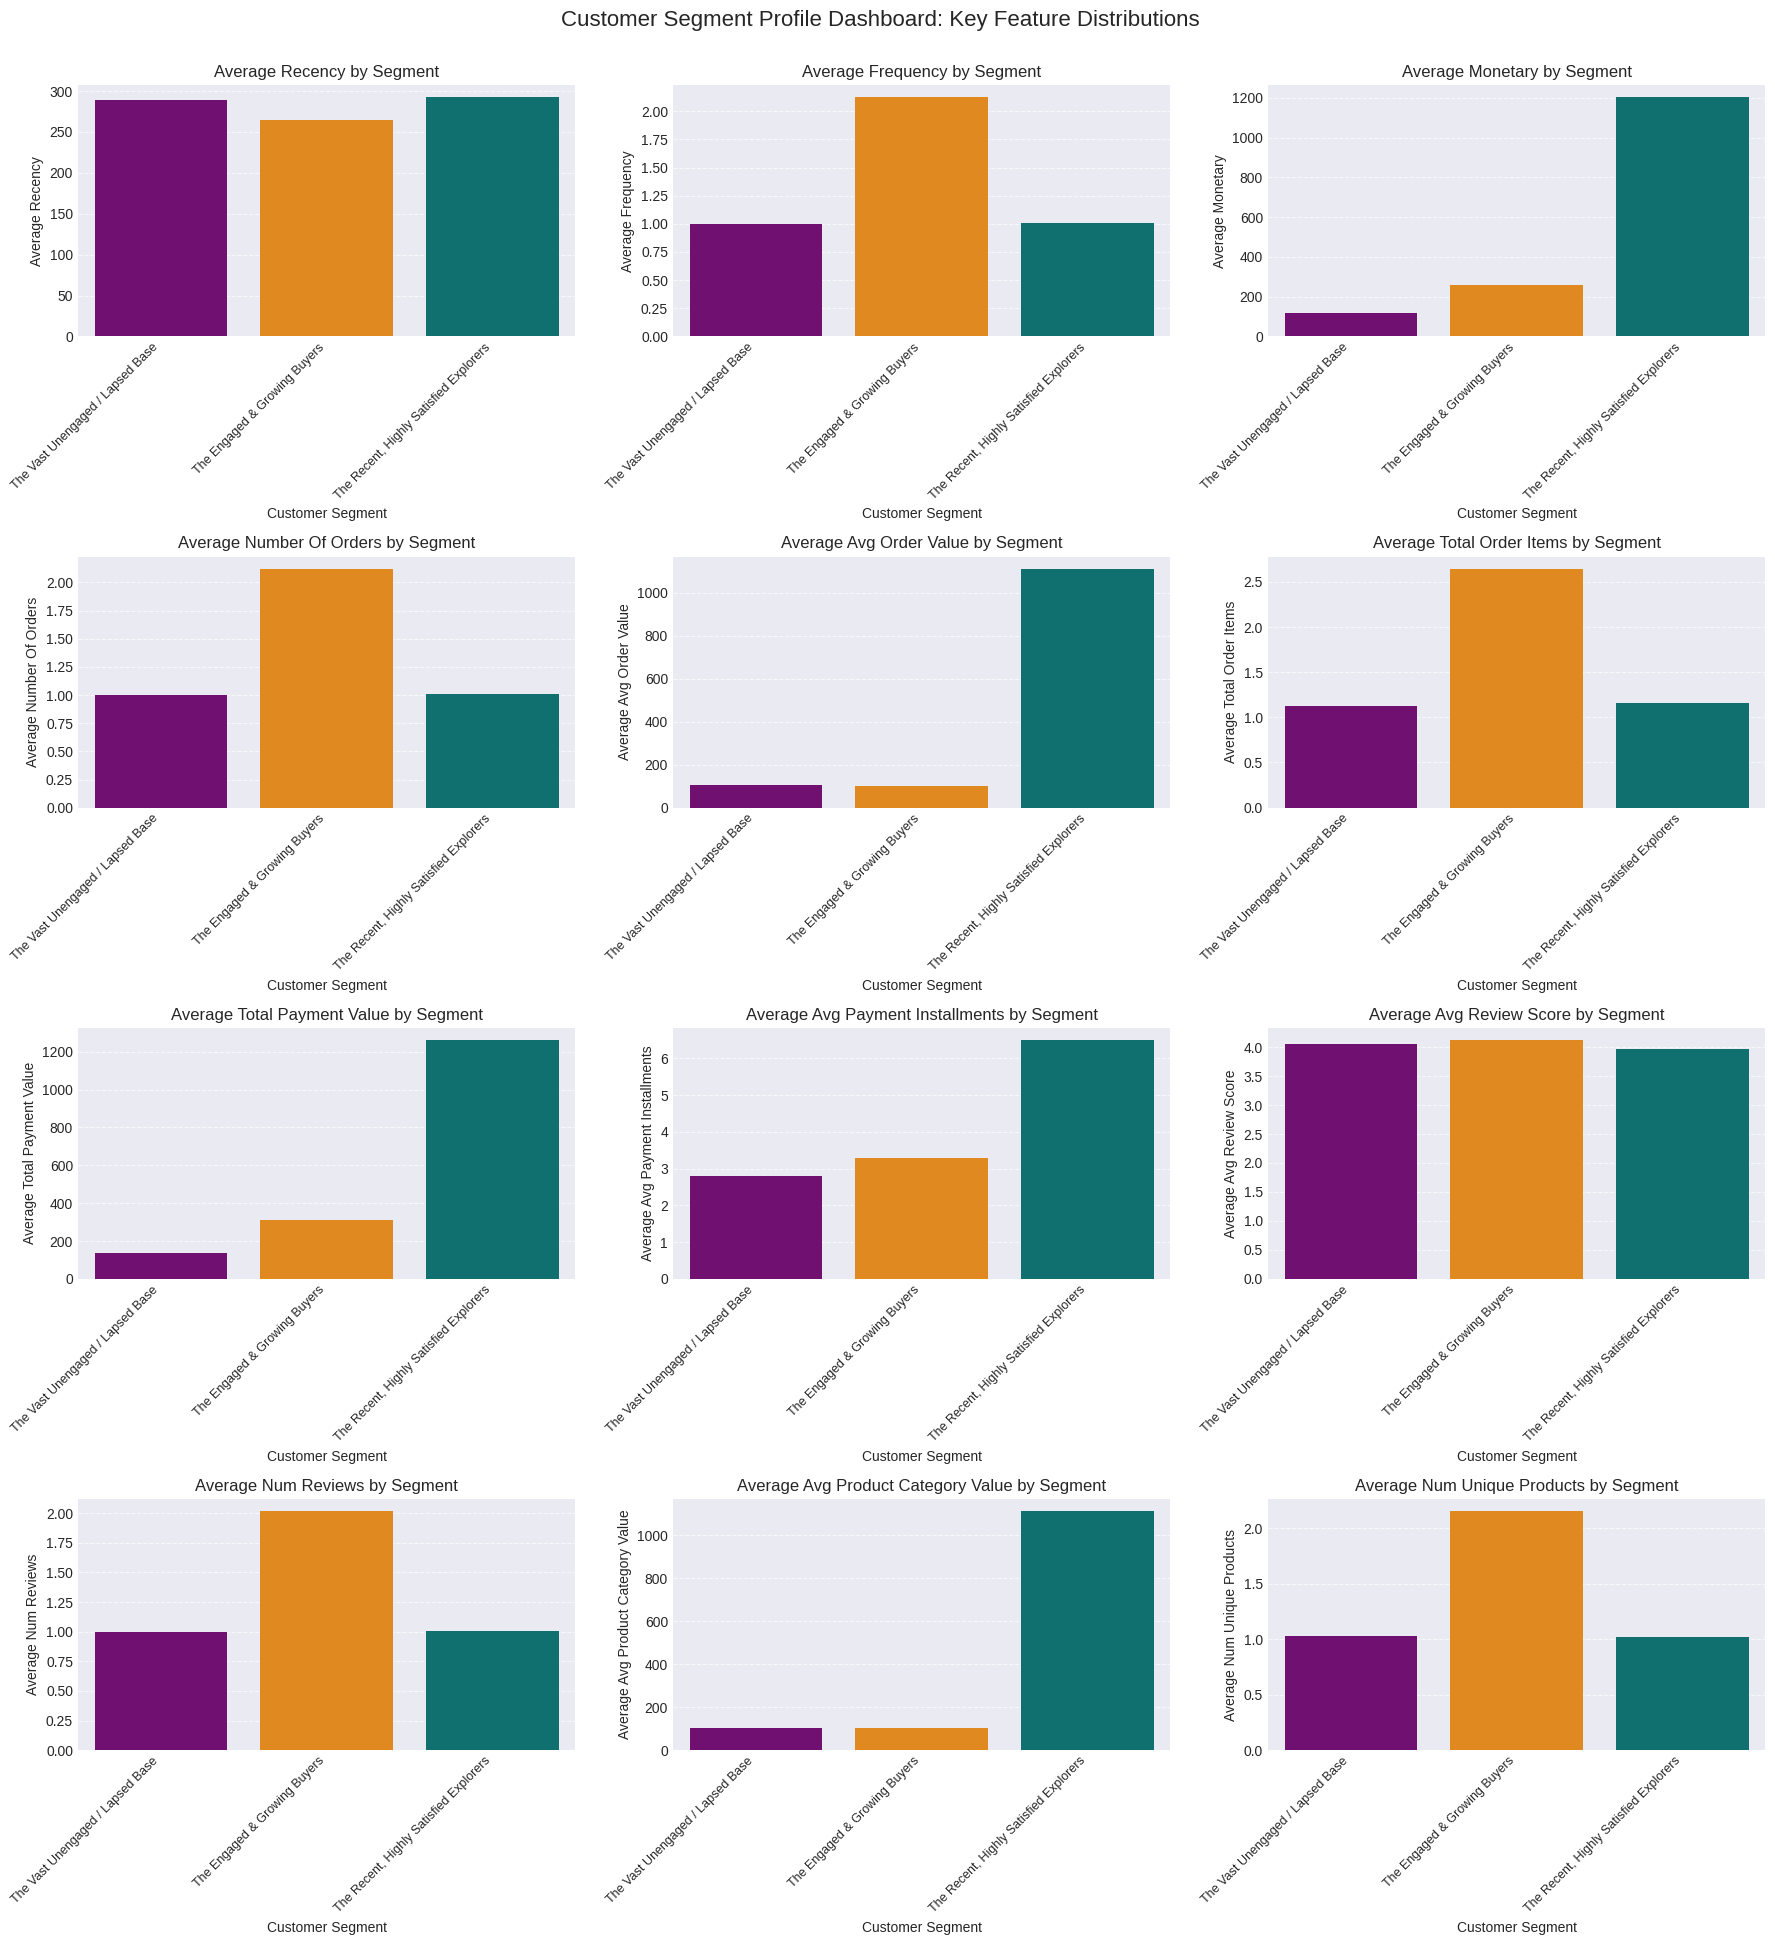

Customer Segment Profile Dashboard generated successfully.
This dashboard visualizes the average values of key features for each customer segment.
It helps to further understand and differentiate the characteristics of each segment.


In [51]:
# Customer Segment Profile Dashboard

# Ensure customer_segments_df and SEGMENT_NAMES are defined
if 'customer_segments_df' not in locals() or 'SEGMENT_NAMES' not in globals():
    print("Error: 'customer_segments_df' or 'SEGMENT_NAMES' not found. Please run previous cells first.")
else:
    print("\n--- Customer Segment Profile Dashboard: Key Feature Distributions ---")

    # Map segment IDs to names for plotting
    customer_segments_df['segment_name'] = customer_segments_df['segment_id'].map(SEGMENT_NAMES)

    # Define the features to plot
    features_to_profile = [
        'Recency', 'Frequency', 'Monetary', 'number_of_orders', 'avg_order_value',
        'total_order_items', 'total_payment_value', 'avg_payment_installments',
        'avg_review_score', 'num_reviews', 'avg_product_category_value', 'num_unique_products'
    ]

    # Create a custom color palette for segments
    segment_colors = {
        0: 'purple',
        1: 'darkorange',
        2: 'teal'
    }

    # Ensure the color list is ordered by segment ID for consistent plotting
    ordered_segment_ids = sorted(customer_segments_df['segment_id'].unique())
    ordered_colors = [segment_colors[sid] for sid in ordered_segment_ids]

    # Plotting loop for each feature
    num_plots = len(features_to_profile)
    num_cols = 3
    num_rows = int(np.ceil(num_plots / num_cols))

    plt.figure(figsize=(num_cols * 6, num_rows * 5))

    for i, feature in enumerate(features_to_profile):
        ax = plt.subplot(num_rows, num_cols, i + 1)

        # Calculate average for the feature by segment
        segment_avg = customer_segments_df.groupby('segment_name')[feature].mean().reindex([SEGMENT_NAMES[sid] for sid in sorted(SEGMENT_NAMES.keys())])

        # Plot the bar chart
        sns.barplot(x=segment_avg.index, y=segment_avg.values, hue=segment_avg.index, palette=ordered_colors, ax=ax, legend=False)

        ax.set_title(f'Average {feature.replace("_", " ").title()} by Segment', fontsize=12)
        ax.set_xlabel('Customer Segment', fontsize=10)
        ax.set_ylabel(f'Average {feature.replace("_", " ").title()}', fontsize=10)

        # Get the current tick locations and labels
        tick_locs = ax.get_xticks()
        tick_labels = ax.get_xticklabels()

        # Set the labels with the desired rotation and alignment, using the fixed tick locations
        ax.set_xticks(tick_locs)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=9)

        ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout to prevent title and label overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.suptitle('Customer Segment Profile Dashboard: Key Feature Distributions', fontsize=16, y=1.0)
    plt.show()

    print("Customer Segment Profile Dashboard generated successfully.")
    print("This dashboard visualizes the average values of key features for each customer segment.")
    print("It helps to further understand and differentiate the characteristics of each segment.")

In [52]:
# BigQuery Write Operations
print("\n--- Writing Segmented Data to BigQuery ---")

# Create a new dim_customer_segmented table/overwrite existing
table_id_customer_segmented = f"{project_id}.{dataset}.dim_customer_segmented"
job_config_customer_segmented = LoadJobConfig(write_disposition=WriteDisposition.WRITE_TRUNCATE)

print(f"Attempting to write dim_customer_segmented to {table_id_customer_segmented}...")
try:
    job = client.load_table_from_dataframe(customer_segments_df, table_id_customer_segmented, job_config=job_config_customer_segmented)
    job.result()
    print(f"✅ Loaded {job.output_rows} rows into {table_id_customer_segmented}")
except Exception as e:
    print(f"❌ Failed to write dim_customer_segmented to BigQuery: {e}")

# Create a new dim_segment table/overwrite existing
table_id_dim_segment = f"{project_id}.{dataset}.dim_segment"
job_config_dim_segment = LoadJobConfig(write_disposition=WriteDisposition.WRITE_TRUNCATE)

print(f"Attempting to write dim_segment to {table_id_dim_segment}...")
try:
    job = client.load_table_from_dataframe(dim_segment_df, table_id_dim_segment, job_config=job_config_dim_segment)
    job.result()
    print(f"✅ Loaded {job.output_rows} rows into {table_id_dim_segment}")
except Exception as e:
    print(f"❌ Failed to write dim_segment to BigQuery: {e}")


--- Writing Segmented Data to BigQuery ---
Attempting to write dim_customer_segmented to module-2-assignment-project.analytics_olist_ecommerce.dim_customer_segmented...
✅ Loaded 96866 rows into module-2-assignment-project.analytics_olist_ecommerce.dim_customer_segmented
Attempting to write dim_segment to module-2-assignment-project.analytics_olist_ecommerce.dim_segment...
✅ Loaded 3 rows into module-2-assignment-project.analytics_olist_ecommerce.dim_segment
